# Super-resolution sử dụng kỹ thuật CNN:

## Thiết lập môi trường:


### Cài đặt các công cụ cần thiết:

In [2]:
# Kết nối với Drive:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Clone repository từ Github:
%cd /content/gdrive/MyDrive
!git clone https://github.com/NHuy165/Group-Project---Super-resolution.git
%cd Group-Project---Super-resolution

/content/gdrive/MyDrive
Cloning into 'Group-Project---Super-resolution'...
remote: Enumerating objects: 177, done.
remote: Counting objects: 100% (177/177), done.
remote: Compressing objects: 100% (156/156), done.
remote: Total 177 (delta 53), reused 35 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (177/177), 37.78 MiB | 8.85 MiB/s, done.
Resolving deltas: 100% (53/53), done.
/content/gdrive/MyDrive/Group-Project---Super-resolution


In [4]:
# Tải các thư viện cần thiết:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.2/155.2 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.9 MB/s eta 0:00:00
ERROR: Ignored the following versions that require a different python version: 1.6.2 Requires-Python >=3.7,<3.10; 1.6.3 Requires-Python >=3.7,<3.10; 1.7.0 Requires-Python >=3.7,<3.10; 1.7.1 Requires-Python >=3.7,<3.10
ERROR: Could not find a version that satisfies the requirement tensorflow-intel==2.15.0 (from versions: 0.0.1)
ERROR: No matching distribution found for tensorflow-intel==2.15.0


### Cài đặt thư viện:

In [5]:
# Import các thư viện:
import os
import math
import PIL
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from keras.applications import vgg16
from tensorflow.keras.preprocessing.image import load_img, array_to_img, img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from IPython.display import display

## Thu thập và xử lý dữ liệu:

### Thu thập dữ liệu:

In [6]:
url = "https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz"
# Dữ liệu gồm 500 hình ảnh.

data_path = tf.keras.utils.get_file(origin=url, untar=True, fname="BSR")
root_path = os.path.join(data_path, "BSDS500/data")



70763455/70763455 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


### Phân loại dữ liệu:

In [7]:
# Quy định về kích thước ảnh đầu ra mặc định (target_size) là 300x300 và ảnh đầu vào luôn được giảm xuống kích thước mặc định là 100x100. batch_size được quy định là 8.
target_size = 300
upscale_factor = 3
input_size = target_size // upscale_factor
batch_size = 8

# Phân loại dữ liệu thành dữ liệu huấn luyện (training dataset) và dữ liệu kiểm tra (validation dataset), đồng thời chuẩn hóa kích thước thành 300x300.
train_data_raw = tf.keras.preprocessing.image_dataset_from_directory(
    root_path,
    batch_size = batch_size,
    label_mode=None,
    image_size=(target_size, target_size),
    validation_split=0.2,
    subset="training",
    seed=1337
)

validate_data_raw = tf.keras.preprocessing.image_dataset_from_directory(
    root_path,
    batch_size = batch_size,
    label_mode=None,
    image_size=(target_size, target_size),
    validation_split=0.2,
    subset="validation",
    seed=1337
)

Found 500 files.
Using 400 files for training.
Found 500 files.
Using 100 files for validation.


### Xử lý dữ liệu:

#### Chuẩn hóa pixel:

In [8]:
# Chuẩn hóa giá trị pixel của mỗi ảnh từ [0, 255] về [0, 1].
def scale(img):
    return (img)/255.0

train_data = train_data_raw.map(scale)
validate_data = validate_data_raw.map(scale)

#### Tiền xử lý chi tiết:

In [9]:
# process_input chuyển đổi ảnh sang không gian màu YUV và tách kênh màu Y, sau đó chỉnh lại kích cỡ ảnh.
def process_input(img, new_size, upscale_factor):
    img = tf.image.rgb_to_yuv(img)
    y = tf.split(img, 3, axis = len(img.shape)-1)[0]
    return tf.image.resize(y, [new_size, new_size], method="area")

# process_target tương tự process_input nhưng không chỉnh lại kích cỡ ảnh.
def process_target(img):
    img = tf.image.rgb_to_yuv(img)
    y = tf.split(img, 3, axis=len(img.shape)-1)[0]
    return y

# Áp dụng hai hàm vào dữ liệu, đồng thời tăng tốc độ nạp.
train_data_scaled = train_data.map(
    lambda img: (process_input(img, input_size, upscale_factor), process_target(img))
)

train_ds = train_data_scaled.prefetch(buffer_size=32)

validate_data_scaled = validate_data.map(
    lambda img: (process_input(img, input_size, upscale_factor), process_target(img))
)

valid_ds = validate_data_scaled.prefetch(buffer_size=32)


#### Hiển thị và kiểm tra:

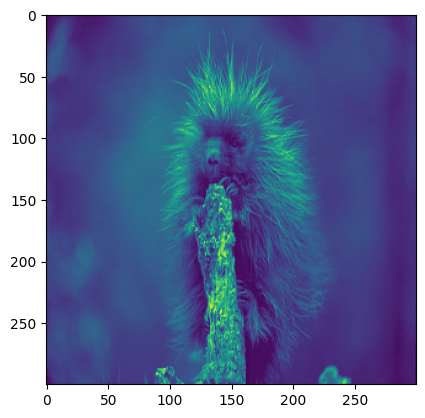

<Figure size 30000x30000 with 0 Axes>

(300, 300) 



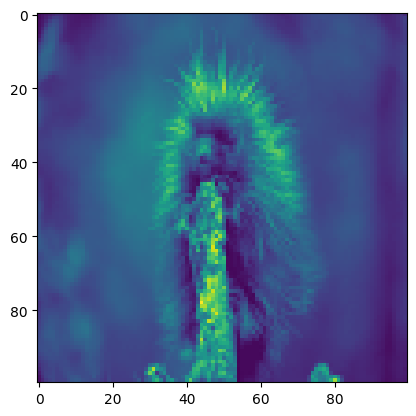

<Figure size 10000x10000 with 0 Axes>

(100, 100)


In [10]:
l = list(train_ds)

img1 = tf.keras.preprocessing.image.array_to_img(l[0][1][0])
plt.imshow(img1)
plt.figure(figsize=(img1.size[0], img1.size[1]))
plt.show()
print(img1.size,"\n")

img2 = tf.keras.preprocessing.image.array_to_img(l[0][0][0])
plt.imshow(img2)
plt.figure(figsize=(img2.size[0], img2.size[1]))
plt.show()
print(img2.size)

## Xây dựng và huấn luyện mô hình:

### Xây dựng mô hình cơ sở:

#### Xây dựng lớp DepthToSpaceLayer:

In [11]:
# Lớp tùy chỉnh trong Keras có nhiệm vụ tái tổ chức không gian:
from tensorflow.keras.layers import Layer
import tensorflow as tf

class DepthToSpaceLayer(Layer):
    def __init__(self, block_size, **kwargs):
        super(DepthToSpaceLayer, self).__init__(**kwargs)
        self.block_size = block_size

    def call(self, inputs):
        return tf.nn.depth_to_space(inputs, block_size=self.block_size)

    def get_config(self):
        config = super(DepthToSpaceLayer, self).get_config()
        config.update({"block_size": self.block_size})
        return config

#### Xây dựng hàm tạo mô hình:

In [12]:
# Hàm lấy mô hình cơ sở
def get_model(upscale_factor=3, channels=1):
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    inputs = keras.Input(shape=(None, None, channels))
    x = layers.Conv2D(64, 5, **conv_args)(inputs)
    x = layers.Conv2D(64, 3, **conv_args)(x)
    x = layers.Conv2D(32, 3, **conv_args)(x)
    x = layers.Conv2D(channels * (upscale_factor ** 2), 3, **conv_args)(x)
    outputs = DepthToSpaceLayer(upscale_factor)(x)

    return keras.Model(inputs, outputs)

### Xây dựng công cụ theo dõi và đánh giá quá trình huấn luyện:

#### Xây dựng các hàm cần thiết:

In [13]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL

# Hiển thị ảnh với phần phóng to để quan sát độ hiệu quả mô hình.
def plot_results(img, prefix, title):
    """Plot the result with zoom-in area."""
    img_array = img_to_array(img)
    img_array = img_array.astype("float32") / 255.0

    # Create a new figure with a default 111 subplot.
    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin="lower")

    plt.title(title)
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img_array[::-1], origin="lower")

    # Specify the limits.
    x1, x2, y1, y2 = 200, 300, 100, 200
    # Apply the x-limits.
    axins.set_xlim(x1, x2)
    # Apply the y-limits.
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False)
    plt.xticks(visible=False)

    # Make the line.
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
    plt.savefig(str(prefix) + "-" + title + ".png")
    plt.show()

# Lấy ảnh thu nhỏ bằng nội suy song khối.
def get_lowres_image(img, upscale_factor):
    """Return low-resolution image to use as model input."""
    return img.resize(
        (img.size[0] // upscale_factor, img.size[1] // upscale_factor),
        PIL.Image.BICUBIC,
    )

# Áp dụng mô hình để dự đoán.
def upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis=0)
    out = model.predict(input)

    out_img_y = out[0]
    out_img_y *= 255.0

    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
        "RGB"
    )
    return out_img

#### Xây dựng các cơ chế kiểm soát quá trình huấn luyện:

In [14]:
dataset = os.path.join(root_path, "images")
test_path = os.path.join(dataset, "test")

test_img_paths = sorted(
    [
        os.path.join(test_path, fname)
        for fname in os.listdir(test_path)
        if fname.endswith(".jpg")
    ]
)

# Lớp tổng hợp các hàm để kiểm soát quá trình huấn luyện:
class ESPCNCallback(keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.test_img = get_lowres_image(load_img(test_img_paths[0]), upscale_factor)

    # Store PSNR value in each epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnr = []

    def on_test_batch_end(self, batch, logs=None):
        self.psnr.append(10 * math.log10(1 / logs["loss"]))

    def on_epoch_end(self, epoch, logs=None):
        print("Mean PSNR for epoch: %.2f" % (np.mean(self.psnr)))
        if epoch % 20 == 0:
            prediction = upscale_image(self.model, self.test_img)
            plot_results(prediction, "epoch-" + str(epoch), "prediction")

In [15]:
# Cơ chế dừng huấn luyện sớm nếu hiệu quả mô hình không thay đổi.
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)

In [16]:
# Lưu mô hình nếu hiệu quả cao nhất.
checkpoint_filepath = "/tmp/checkpoint.weights.h5"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

### Huấn luyện mô hình:

#### Tổng kết các công cụ cần thiết:

In [17]:
model = get_model(upscale_factor=upscale_factor, channels=1)
model.summary()

callbacks = [ESPCNCallback(), early_stopping_callback, model_checkpoint_callback]
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, None, 1)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, None, None, 64)      │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, None, None, 32)      │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, None, None, 9)       │           2,601 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ depth_to_space_layer                 │ (None, None, None, 1)       │               0 │
│ (DepthToSpaceLayer)                  │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 59,657 (233.04 KB)

 Trainable params: 59,657 (233.04 KB)

 Non-trainable params: 0 (0.00 B)

#### Huấn luyện và lưu mô hình:

Epoch 1/300
Mean PSNR for epoch: 22.33
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


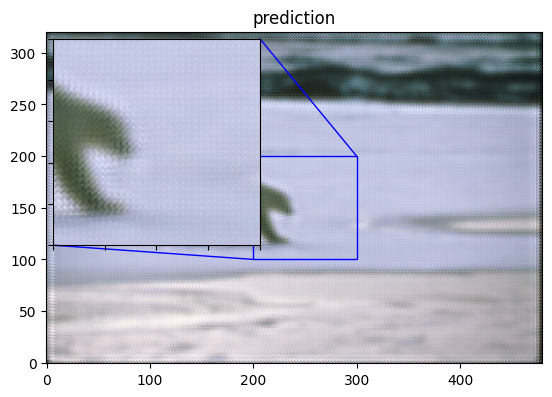

50/50 - 63s - 1s/step - loss: 0.0316 - val_loss: 0.0060
Epoch 2/300


KeyboardInterrupt: 

In [18]:
epochs = 300

model.compile(
    optimizer=optimizer, loss=loss_fn,
)

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=valid_ds, verbose=2
)

# Tải lại các trọng số tốt nhất vào mô hình trước khi lưu:
model.load_weights(checkpoint_filepath)

In [ ]:
# Tạo thư mục Models và thư mục con image_upscale_model:
%cd ../
!mkdir Models
!mkdir Models/image_upscale_model

# Lưu model vào thư mục Models/image_upscale_model:
model_save_path = 'Models/image_upscale_model/my_model.keras'
model.save(model_save_path)

## Chạy mô hình:

In [ ]:
# Tải mô hình.
model_path = 'Models/image_upscale_model/my_model.keras'
model = keras.models.load_model(model_path, custom_objects={"DepthToSpaceLayer": DepthToSpaceLayer})

In [ ]:
# Tạo thư mục prediction để lưu các dự đoán của model
!mkdir predictions
%cd predictions

In [ ]:
# Chạy và đánh giá mô hình:
total_bicubic_psnr = 0.0
total_test_psnr = 0.0

for index, test_img_path in enumerate(test_img_paths[50:60]):
    img = load_img(test_img_path)
    lowres_input = get_lowres_image(img, upscale_factor)

    w = lowres_input.size[0] * upscale_factor
    h = lowres_input.size[1] * upscale_factor

    prediction = upscale_image(model, lowres_input)

    # Thống nhất lại kích cỡ các hình ảnh:
    lowres_img = lowres_input.resize((w, h))
    lowres_img_arr = img_to_array(lowres_img)
    highres_img = img.resize((w, h))
    highres_img_arr = img_to_array(highres_img)
    predict_img_arr = img_to_array(prediction)

    # Tính PSNR của nội suy song khối và mô hình:
    bicubic_psnr = tf.image.psnr(lowres_img_arr, highres_img_arr, max_val=255)
    test_psnr = tf.image.psnr(predict_img_arr, highres_img_arr, max_val=255)

    # Cập nhật PSNR:
    total_bicubic_psnr += bicubic_psnr
    total_test_psnr += test_psnr

    print("PSNR of low resolution image and high resolution image is %.4f" % bicubic_psnr)
    print("PSNR of predict and high resolution is %.4f" % test_psnr)

    # Lưu ảnh trực tiếp trong thư mục hiện tại
    lowres_output_path = f"lowres_{index}.png"
    highres_output_path = f"highres_{index}.png"
    prediction_output_path = f"prediction_{index}.png"

    lowres_img.save(lowres_output_path)
    highres_img.save(highres_output_path)
    prediction.save(prediction_output_path)

    # Hiển thị kết quả:
    plot_results(lowres_img, index, "lowres")
    plot_results(prediction, index, "prediction")
    plot_results(highres_img, index, "highres")

# PSNR trung bình:
print("Avg. PSNR of lowres images is %.4f" % (total_bicubic_psnr / 10))
print("Avg. PSNR of reconstructions is %.4f" % (total_test_psnr / 10))


## Chạy app.py để triển khai web:

In [ ]:
%cd /content/gdrive/MyDrive/Group-Project---Super-resolution

In [ ]:
from google.colab import output
output.serve_kernel_port_as_window(5000)

In [ ]:
!python app.py